In [15]:
import xml.etree.ElementTree as ET
import re
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt

# 常量定义

In [16]:
# 常量
xml_path = "./xml/TT_test.xml"
rod_length = 1

# Utilities

In [17]:
# 优化代码格式，写完xml后，运行该函数，使xml文件更易读
def prettify(elem, level=0):
    indent = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = indent + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
        for elem in elem:
            prettify(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = indent

# 指定杆名字和两端坐标，在文件中生成杆件
def generate_rod_element(root, rod_name:str, fromto_coords, mass:Optional[str]=None, rod_radius='0.014'):
    assert len(fromto_coords) == 6 and all(isinstance(coord, (int, float)) for coord in fromto_coords), "fromto_coords必须是包含六个数字的列表"
    match = re.match(r"rod(\d+)_(\d+)", rod_name)
    assert match, "rod_name必须符合rodx_y的格式"
    assert mass is None or (isinstance(mass, str) and mass.isdigit()), "mass must be a string representing a number"
    
    x_str = match.group(1)
    y_str = match.group(2)
    x_str = str(x_str)
    y_str = str(y_str)
    
    fromto_coords_str = "{} {} {} {} {} {}".format(fromto_coords[0], fromto_coords[1], fromto_coords[2], fromto_coords[3], fromto_coords[4], fromto_coords[5])
    from_point_coords_str =  "{} {} {}".format(fromto_coords[0], fromto_coords[1], fromto_coords[2])
    to_point_coords_str =  "{} {} {}".format(fromto_coords[3], fromto_coords[4], fromto_coords[5])
    
    midpoint_coords = [(fromto_coords[0] + fromto_coords[3]) / 2, 
                   (fromto_coords[1] + fromto_coords[4]) / 2, 
                   (fromto_coords[2] + fromto_coords[5]) / 2]
    midpoint_coords_str = "{} {} {}".format(midpoint_coords[0], midpoint_coords[1], midpoint_coords[2])
    
    new_body = ET.Element('body')
    new_body.set('name', rod_name)
    new_body.set('pos', midpoint_coords_str)

    joint = ET.Element('joint')
    joint.set('type', 'free')
    joint.set('name', 'joint' + x_str + '_' + y_str)

    geom = ET.Element('geom')
    geom.set('name', 'geom' + x_str + '_' + y_str)
    geom.set('type', 'cylinder')
    geom.set('fromto', fromto_coords_str)
    if mass is not None:
        geom.set('mass', mass)
    else:
        geom.set('density', '1000')
    geom.set('size', rod_radius)

    site1 = ET.Element('site')
    site1.set('name', 's' + x_str)
    site1.set('pos', from_point_coords_str)

    site2 = ET.Element('site')
    site2.set('name', 's' + y_str)
    site2.set('pos', to_point_coords_str)

    new_body.append(joint)
    new_body.append(geom)
    new_body.append(site1)
    new_body.append(site2)
    # 将新的<body>子元素添加到<worldbody>的最后
    worldbody = root.find('worldbody')
    worldbody.append(new_body)

# 指定绳索两端的点，在文件中生成绳索
def generate_tendon_object(root, from_site_name:str, to_site_name:str, stiffness:Optional[str]=None):
    match1 = re.match(r"s(\d)", from_site_name)
    assert match1, "from_site_name必须符合sx的格式"
    match2 = re.match(r"s(\d)", to_site_name)
    assert match2, "to_site_name必须符合sx的格式"
    assert stiffness is None or (isinstance(stiffness, str) and stiffness.isdigit()), "stiffness must be a string representing a number"

    x_str = match1.group(1)
    y_str = match2.group(1)
    x_str = str(x_str)
    y_str = str(y_str)

    new_spatial = ET.Element('spatial')
    new_spatial.set('name', 'td' + x_str + '_' + y_str)

    if stiffness is not None:
        new_spatial.set('stiffness', stiffness)

    site1 = ET.Element('site')
    site1.set('site', from_site_name)

    site2 = ET.Element('site')
    site2.set('site', to_site_name)

    new_spatial.append(site1)
    new_spatial.append(site2)

    tendon = root.find('tendon')
    tendon.append(new_spatial)

# 删除指定的物体
def remove_body(root, body_name):
    for body in root.iter('body'):
        if body.get('name') == body_name:
            for worldbody in root.iter('worldbody'):
                worldbody.remove(body)
            print(f"成功移除名称为{body_name}的body元素及其所有子元素。")
            return
    print(f"未找到名称为{body_name}的body元素。")

# 删除所有的物体
def remove_all_body(root):
    worldbody = root.find('worldbody')
    bodies = list(worldbody.iter('body'))
    for body in bodies:
        worldbody.remove(body)

# 删除指定的绳索
def remove_tendon(root, spatial_name):
    for spatial in root.iter('spatial'):
        if spatial.get('name') == spatial_name:
            tendon = root.find('tendon')
            tendon.remove(spatial)
            print(f"成功移除名称为{spatial_name}的绳索元素。")
            return
    print(f"未找到名称为{spatial_name}的body元素。")

# 删除所有的绳索
def remove_all_tendon(root):
    tendon = root.find('tendon')
    spatials = list(tendon.iter('spatial'))
    for spatial in spatials:
        tendon.remove(spatial)
   

# 底层函数示例

In [75]:
# 示例：读取文件+获取文件信息
tree = ET.parse(xml_path)
root = tree.getroot()
for geom in root.iter('geom'):
    size = geom.get('size')
    print(size)

None
20 20 0.125


In [76]:
# 示例：生成杆件
tree = ET.parse(xml_path)
root = tree.getroot()
generate_rod_element(root, "rod0_1", [0, 0, 2, 1, 2, 2])  
prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)

In [77]:
# 示例：删除杆件
tree = ET.parse(xml_path)
root = tree.getroot()
remove_body(root, "rod0_1")
prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)

成功移除名称为rod0_1的body元素及其所有子元素。


In [78]:
# 示例：生成绳索
tree = ET.parse(xml_path)
root = tree.getroot()
generate_rod_element(root, "rod0_1", [0, 0, 0, 0, 0, 2])
generate_rod_element(root, "rod2_3", [1, 0, 0, 1, 0, 2])
generate_tendon_object(root, "s1", "s3")
prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)

In [79]:
# 示例：删除特定绳索
tree = ET.parse(xml_path)
root = tree.getroot()
remove_tendon(root, "td1_3")
prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)

成功移除名称为td1_3的绳索元素。


In [80]:
# 示例：删除所有的杆件
tree = ET.parse(xml_path)
root = tree.getroot()
remove_all_body(root)
prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)

In [73]:
# 示例：删除所有的绳索
tree = ET.parse(xml_path)
root = tree.getroot()
remove_all_tendon(root)
prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)

# 构建张拉整体结构
1 定义所有节点位置，使用numpy列向量表示\
2 定义连接矩阵\
3 matplot绘图，确保正确\
4 整体位置偏移

## Utilities

In [18]:
def tenseg_ind2C(C_ind, Nodes):
    """
    Creates a connectivity matrix from input index notation array and node matrix.

    Inputs:
        C_ind: index connectivity array (m x 2 array for m members)
        Nodes: node matrix (3 x n array for n nodes)

    Outputs:
        C_mat: connectivity matrix (m x n matrix satisfying M = N*C')

    Example: If given four nodes (N is a 3x4 matrix), and you want one bar to
    be the vector from node 1 to 3, and another bar from node 2 to 4, input
    C_ind would be: C_ind = np.array([[1, 3], [2, 4]])

    C_b = tenseg_ind2C(np.array([[1, 3], [2, 4]]), N)
    """
    nmembers = C_ind.shape[0]  # Number of members being created
    n = Nodes.shape[1]  # Number of nodes in the structure

    # Initialize connectivity matrix
    C_mat = np.zeros((n, nmembers))

    for i in range(nmembers):  # Go through each member
        # Get indices for start and end points
        side1 = C_ind[i, 0]
        side2 = C_ind[i, 1]

        # Put -1 at index for start point, 1 at index for end point
        C_mat[side1 - 1, i] = -1
        C_mat[side2 - 1, i] = 1

    return C_mat.T

def tenseg_plot(N, C_b, C_s, show_labels=False):
    BarWidth = 2
    StringWidth = 1
    NodeSize = 25

    # Get difference between min and max values for each axis
    fig_out = plt.figure()
    ax = fig_out.add_subplot(111, projection='3d')

    # Plot bar member vectors
    if len(C_b) > 0:
        B = np.dot(N, C_b.T)
        bar_start_nodes = np.zeros((3, B.shape[1]))
        bar_end_nodes = np.zeros((3, B.shape[1]))
        for j in range(B.shape[1]):
            bar_start_nodes[:,j] = np.squeeze(N[:, C_b[j,:] == -1])
            bar_end_nodes[:,j] = np.squeeze(N[:, C_b[j,:] == 1])

        for j in range(B.shape[1]):
            ax.plot([bar_start_nodes[0,j], bar_end_nodes[0,j]], [bar_start_nodes[1,j], bar_end_nodes[1,j]], [bar_start_nodes[2,j], bar_end_nodes[2,j]], color='black', linewidth=BarWidth)
            if show_labels:
                ax.text((bar_start_nodes[0,j] + bar_end_nodes[0,j])/2, (bar_start_nodes[1,j] + bar_end_nodes[1,j])/2, (bar_start_nodes[2,j] + bar_end_nodes[2,j])/2, str(j+1), color='black')
        # ax.quiver(bar_start_nodes[0,:], bar_start_nodes[1,:], bar_start_nodes[2,:], B[0,:], B[1,:], B[2,:], color='black', linewidth=BarWidth)

    # Plot string member vectors
    if len(C_s) > 0:
        S = np.dot(N, C_s.T)
        string_start_nodes = np.zeros((3, S.shape[1]))
        string_end_nodes = np.zeros((3, S.shape[1]))
        for j in range(S.shape[1]):
            string_start_nodes[:,j] = np.squeeze(N[:, C_s[j,:] == -1])
            string_end_nodes[:,j] = np.squeeze(N[:, C_s[j,:] == 1])
        for j in range(S.shape[1]):
            ax.plot([string_start_nodes[0,j], string_end_nodes[0,j]], [string_start_nodes[1,j], string_end_nodes[1,j]], [string_start_nodes[2,j], string_end_nodes[2,j]], color='red', linewidth=StringWidth)
            if show_labels:
                ax.text((string_start_nodes[0,j] + string_end_nodes[0,j])/2, (string_start_nodes[1,j] + string_end_nodes[1,j])/2, (string_start_nodes[2,j] + string_end_nodes[2,j])/2, str(j+1), color='red')  # Add string labels

    ax.scatter(N[0,:], N[1,:], N[2,:], color='blue', s=NodeSize)
    if show_labels:
        for i in range(N.shape[1]):
            ax.text(N[0,i], N[1,i], N[2,i], str(i+1), color='blue')  # Add node labels
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
        # ax.quiver(string_start_nodes[0,:], string_start_nodes[1,:], string_start_nodes[2,:], S[0,:], S[1,:], S[2,:], color='red', linestyle='-', linewidth=StringWidth)

# 使所有节点整体移动一个距离
def move_nodes(node_positions, x, y, z):
    moved_positions = node_positions + np.array([[x], [y], [z]])
    return moved_positions

## 示例 构建Prism机构
首先pyhon画出来，看是否准确

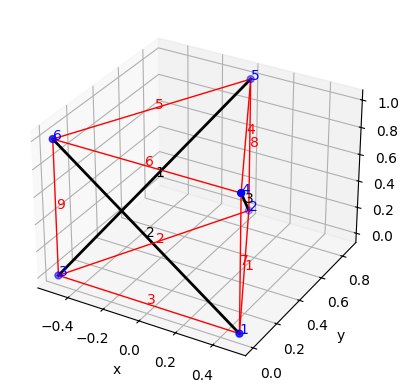

In [10]:
# Specify node positions
N = np.array([[0.5, 0, 0], [0, 0.866, 0], [-0.5, 0, 0], [0.5, 0, 1], [0, 0.866, 1], [-0.5, 0, 1]]).T

# Specify bar connectivity
Cb_in = np.array([[3, 5], [1, 6], [2, 4]])  # Bar 1 connects node 3 to 5, etc
C_b = tenseg_ind2C(Cb_in, N)

# Specify string connectivity
Cs_in = np.array([[1, 2], [2, 3], [3, 1], [4, 5], [5, 6], [6, 4], [1, 4], [2, 5], [3, 6]])  # String one is node 1 to 2
C_s = tenseg_ind2C(Cs_in, N)

# print(C_b)
# print(C_s)
# Plot structure before string segmentation
tenseg_plot(N, C_b, C_s, show_labels=True)

# print(move_nodes(N, 1,2,3))


3

## 加载到xml文件中去

In [19]:
def load_tensegrity_to_xml(root, N, C_b, C_s):

    remove_all_body(root)
    remove_all_tendon(root)

    if len(C_b) > 0:
        B = np.dot(N, C_b.T)
        bar_start_nodes = np.zeros((3, B.shape[1]))
        bar_end_nodes = np.zeros((3, B.shape[1]))
        for j in range(B.shape[1]):
            bar_start_nodes[:,j] = np.squeeze(N[:, C_b[j,:] == -1])
            bar_end_nodes[:,j] = np.squeeze(N[:, C_b[j,:] == 1])
            print(bar_start_nodes[:,j])
            print(bar_end_nodes[:,j])
            generate_rod_element(root, rod_name=f'rod{np.argmax(C_b[j,:] == -1)}_{np.argmax(C_b[j,:] == 1)}', fromto_coords=bar_start_nodes[:, j].tolist()+bar_end_nodes[:, j].tolist())
        # print(bar_start_nodes)
        # print('\n',bar_end_nodes)

        # generate_rod_element(root, rod_name=f'rod{}')

    # Plot string member vectors
    if len(C_s) > 0:
        S = np.dot(N, C_s.T)
        for j in range(S.shape[1]):
            generate_tendon_object(root, from_site_name=f's{np.argmax(C_s[j,:] == -1)}', to_site_name=f's{np.argmax(C_s[j,:] == 1)}')


In [20]:
# Specify node positions
N = np.array([[0.5, 0, 0], [0, 0.866, 0], [-0.5, 0, 0], [0.5, 0, 1], [0, 0.866, 1], [-0.5, 0, 1]]).T
# N = move_nodes(N, 0, 0, 2)

# Specify bar connectivity
Cb_in = np.array([[3, 5], [1, 6], [2, 4]])  # Bar 1 connects node 3 to 5, etc
C_b = tenseg_ind2C(Cb_in, N)


# Specify string connectivity
Cs_in = np.array([[1, 2], [2, 3], [3, 1], [4, 5], [5, 6], [6, 4], [1, 4], [2, 5], [3, 6]])  # String one is node 1 to 2
C_s = tenseg_ind2C(Cs_in, N)


tree = ET.parse(xml_path)
root = tree.getroot()
load_tensegrity_to_xml(root, N, C_b, C_s)

prettify(root)
tree.write(xml_path, encoding='utf-8', xml_declaration=True)


[-0.5  0.   0. ]
[0.    0.866 1.   ]
[0.5 0.  0. ]
[-0.5  0.   1. ]
[0.    0.866 0.   ]
[0.5 0.  1. ]


# 其他

In [51]:
B = np.dot(N, C_b.T)
bar_start_nodes = np.zeros((3, B.shape[1]))
bar_end_nodes = np.zeros((3, B.shape[1]))
for j in range(B.shape[1]):
    bar_start_nodes[:,j] = np.squeeze(N[:, C_b[j,:] == -1])
    bar_end_nodes[:,j] = np.squeeze(N[:, C_b[j,:] == 1])
    # generate_rod_element(root, rod_name=f'rod{}', fromto_coords=[])
print(bar_start_nodes)
print('\n',bar_end_nodes)

[[-0.5    0.5    0.   ]
 [ 0.     0.     0.866]
 [ 0.     0.     0.   ]]

 [[ 0.    -0.5    0.5  ]
 [ 0.866  0.     0.   ]
 [ 1.     1.     1.   ]]


In [56]:
bar_start_nodes[:, 1].tolist()+bar_end_nodes[:, 1].tolist()

[0.5, 0.0, 0.0, -0.5, 0.0, 1.0]

In [60]:
index = np.argmax(C_b[1,:] == -1)
print(index)

0


In [24]:

phi = (1 + 5 ** 0.5) / 2
temp = np.array([[0, -1, phi], [0, -1, -phi], [0, 1, phi], [0, 1, -phi]]) / (2 * phi)

N = np.concatenate((temp, temp[:, [2, 0, 1]], temp[:, [1, 2, 0]], [[0, 0, 0]]), axis=0).T
N = N[:, [1, 3, 5, 7, 9, 11, 0, 2, 4, 6, 8, 10, 12]]
N = N - np.ones((1, N.shape[1])) @ N[:, [0]]


print(N)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 13)

In [31]:
import numpy as np

phi = (1 + 5 ** 0.5) / 2
temp = np.array([[0, -1, phi], [0, -1, -phi], [0, 1, phi], [0, 1, -phi]]) / (2 * phi)

N = np.concatenate((temp, temp[:, [2, 0, 1]], temp[:, [1, 2, 0]], [[0, 0, 0]]), axis=0).T
N = N[:, [1, 3, 5, 7, 9, 11, 0, 2, 4, 6, 8, 10, 12]]

print(N)

[[ 0.          0.         -0.5        -0.5        -0.30901699  0.30901699
   0.          0.          0.5         0.5        -0.30901699  0.30901699
   0.        ]
 [-0.30901699  0.30901699  0.          0.         -0.5        -0.5
  -0.30901699  0.30901699  0.          0.          0.5         0.5
   0.        ]
 [-0.5        -0.5        -0.30901699  0.30901699  0.          0.
   0.5         0.5        -0.30901699  0.30901699  0.          0.
   0.        ]]


In [33]:
beta = 6  # There are 6 bars.
Cb = np.hstack((-np.eye(beta), np.eye(beta), np.zeros((beta, 1))))

print(Cb)

[[-1. -0. -0. -0. -0. -0.  1.  0.  0.  0.  0.  0.  0.]
 [-0. -1. -0. -0. -0. -0.  0.  1.  0.  0.  0.  0.  0.]
 [-0. -0. -1. -0. -0. -0.  0.  0.  1.  0.  0.  0.  0.]
 [-0. -0. -0. -1. -0. -0.  0.  0.  0.  1.  0.  0.  0.]
 [-0. -0. -0. -0. -1. -0.  0.  0.  0.  0.  1.  0.  0.]
 [-0. -0. -0. -0. -0. -1.  0.  0.  0.  0.  0.  1.  0.]]


In [38]:

to_site_name = 's10'  # 示例字符串，包含 s 后面的数字

# 使用正则表达式匹配 s 后面的数字
match = re.search(r's(\d+)', to_site_name)
print(match)
number = int(match.group(1))  # 提取匹配的第一个分组，并转换为整数
print(number)

<re.Match object; span=(0, 3), match='s10'>
10


In [1]:
# 创建一个字典
original_dict = {'name': 'John', 'age': 30}

# 要扩展的字典
new_data = {'city': 'New York', 'occupation': 'Engineer'}

# 使用update()方法扩展字典
original_dict.update(new_data)

# 输出扩展后的字典
print(original_dict)

{'name': 'John', 'age': 30, 'city': 'New York', 'occupation': 'Engineer'}


In [6]:

rod_element = []
def generate_rod_element(rod_name:str, **kwargs):
        rod_dict = {'name':rod_name}
        rod_dict.update(kwargs)
        rod_element.append(rod_dict)

In [8]:
generate_rod_element(rod_name="rod0_11",pos='1 2 3',mass='333')
generate_rod_element(rod_name="rod0_1",pos='12 3',mass='333')

print(rod_element)

[{'name': 'rod0_11', 'pos': '1 2 3', 'mass': '333'}, {'name': 'rod0_11', 'pos': '1 2 3', 'mass': '333'}, {'name': 'rod0_1', 'pos': '12 3', 'mass': '333'}]


In [9]:
rod_element = []

def generate_rod_element(rod_name: str, **kwargs):
    # 检查 rod_name 对应的 rod 是否已经存在
    for rod in rod_element:
        if rod['name'] == rod_name:
            print(f"Rod with name '{rod_name}' already exists in rod_element.")
            return
    
    rod_dict = {'name': rod_name}
    rod_dict.update(kwargs)
    rod_element.append(rod_dict)

generate_rod_element(rod_name="rod0_11", pos='1 2 3', mass='333')
print(rod_element)

generate_rod_element(rod_name="rod0_11", pos='4 5 6', mass='444')  # 尝试添加同名的 rod
print(rod_element)

[{'name': 'rod0_11', 'pos': '1 2 3', 'mass': '333'}]
Rod with name 'rod0_11' already exists in rod_element.
[{'name': 'rod0_11', 'pos': '1 2 3', 'mass': '333'}]
